In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/waterQuality/wQuality.csv')

In [4]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['text'].apply(lambda x:len(str(x).split())) 

In [5]:
print('Info about training data:')
print(train_data['corr'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
1    19824
0    18981
Name: corr, dtype: int64
Total comments:  38805


In [6]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[11, 23077, 23077, 710]]


In [7]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['text'],\
                                                      train_data['corr'],\
                                                      test_size=0.3,\
                                                      random_state=0)

In [8]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-8-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-8-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [9]:
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [10]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

[0, 1]

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [12]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

2894     1
36529    0
22543    0
4659     1
13624    1
4738     1
7        1
4296     1
24283    0
28095    0
Name: corr, dtype: int64
Text to number
[1 0 0 1 1 1 1 1 0 0]
Number to category
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [13]:
# Creating CNN Model

# looking for top 30k comments
max_features = 250000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))     

# second is conv. layer.
# 1-dimensional for texts (2D for images)
# kernel_size = 3, looking for 3 words at a time (total of 256).
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 

# adding maxpooling after convolution layer.
# feature map is reduced by half after max pooling.
model.add(tf.keras.layers.GlobalMaxPooling1D())

# final layer, fully connected dense layer.
# 3 neurons for the output: possitive, negative and neutral.
# regularizers prevent overfitting.
model.add(tf.keras.layers.Dense(2, activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                    
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy",  AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           16000000  
                                                                 
 conv1d (Conv1D)             (None, 254, 128)          24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 16,024,962
Trainable params: 16,024,962
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Training model
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs=10,
                    validation_data=test_ds.batch(128),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


213/213 [==============================] - 99s 451ms/step - loss: 0.8080 - categorical_accuracy: 0.9122 - auc: 0.9768 - val_loss: 0.1566 - val_categorical_accuracy: 0.9501 - val_auc: 0.9920
Epoch 2/10
213/213 [==============================] - 90s 425ms/step - loss: 0.1397 - categorical_accuracy: 0.9595 - auc: 0.9945 - val_loss: 0.1517 - val_categorical_accuracy: 0.9531 - val_auc: 0.9924
Epoch 3/10
213/213 [==============================] - 92s 432ms/step - loss: 0.1285 - categorical_accuracy: 0.9663 - auc: 0.9960 - val_loss: 0.1560 - val_categorical_accuracy: 0.9514 - val_auc: 0.9922
Epoch 4/10
213/213 [==============================] - 90s 424ms/step - loss: 0.1234 - categorical_accuracy: 0.9710 - auc: 0.9968 - val_loss: 0.1605 - val_categorical_accuracy: 0.9504 - val_auc: 0.9921
Epoch 5/10
213/213 [==============================] - 93s 435ms/step - loss: 0.1206 - categorical_accuracy: 0.9747 - auc: 0.9973 - val_loss: 0.1638 - val_categorical_accuracy: 0.9519 - val_auc: 0.9919
Epoch 

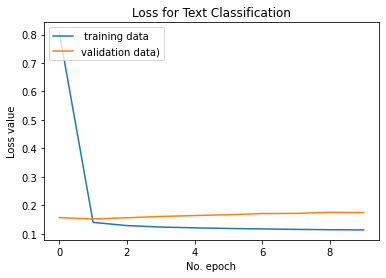

In [15]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

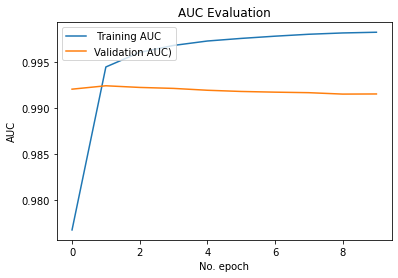

In [16]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [17]:
X_test

20818    why would the governor florida kansas city foo...
7919     globalwarming the global water monitor consort...
10999    noses are vivid violet water lilies are blue s...
27239             nasdaq about days bears better wake soon
30173                                    football specific
                               ...                        
22062                   fifa realistic career mode everton
6368     flash gordon from got for this wonderful examp...
4379     atheists quote reply this tweet with your best...
34052                          chelsea has ruined football
11004    free tarot deck reviews the suits the good tar...
Name: text, Length: 11642, dtype: object

In [18]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-18-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [19]:
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
364/364 [==============================] - 9s 24ms/step


array([0, 1, 1, ..., 0, 0, 1])

In [20]:
y_test.shape
y_test

20818    0
7919     1
10999    1
27239    0
30173    0
        ..
22062    0
6368     1
4379     1
34052    0
11004    1
Name: corr, Length: 11642, dtype: int64

In [21]:
labels = [0, 1]
#labels = labels.values.astype(int).astype(str)
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5733
           1       0.96      0.94      0.95      5909

    accuracy                           0.95     11642
   macro avg       0.95      0.95      0.95     11642
weighted avg       0.95      0.95      0.95     11642

